In [1]:
from matplotlib import pyplot as plt
import numpy as np
import classifier_utils
from classifier_utils import cnn_model, preprocess_img, get_class
%matplotlib inline
import glob
import os
from skimage import io
from skimage import transform
import keras
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.models import Sequential, Model
import vgg16


Using TensorFlow backend.


## Loading CIFAR10

In [2]:
from keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170246144/170498071 [============================>.] - ETA: 0s

In [ ]:
print (y_train[1]) 

### Array details (dimension, type):

In [4]:
print (x_train.shape)

(50000, 32, 32, 3)


In [ ]:
type(x_train)

In [ ]:
print x_train

### Image resizing. Vgg16 takes minimum size of 48x48

In [5]:
x_train_vgg = np.zeros((50000,64,64,3))

for i in range(50000):
    x_train_vgg[i] = transform.resize(x_train[i], (64, 64), order=0)

/usr/local/lib/python3.5/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


### Cutting validation set

In [6]:
size_of_dataset = 50000 #in case of CIFAR 

mask = np.random.rand(size_of_dataset) < 0.8  #array of boolean variables

training_set = x_train_vgg[mask]
training_labels = y_train[mask]

validation_set = x_train_vgg[~mask]
validation_labels = y_train[~mask]

In [7]:
#1st model
#IMG_SIZE = 32
#2nd model
IMG_SIZE = 64 
NUM_CLASSES = 10

### Reducing amount of pictures

In [ ]:
#2nd model
#x_train_vgg = x_train_vgg[0:50000] #bigger value
#y_train_vgg = y_train[0:50000]

In [11]:
print (training_labels.shape)

(39942, 1)


### Why already calculated values? By default on .resize

In [12]:
print (training_set)

[[[[ 0.23137255  0.24313725  0.24705882]
   [ 0.23137255  0.24313725  0.24705882]
   [ 0.16862745  0.18039216  0.17647059]
   ..., 
   [ 0.59607843  0.49019608  0.4       ]
   [ 0.58039216  0.48627451  0.40392157]
   [ 0.58039216  0.48627451  0.40392157]]

  [[ 0.23137255  0.24313725  0.24705882]
   [ 0.23137255  0.24313725  0.24705882]
   [ 0.16862745  0.18039216  0.17647059]
   ..., 
   [ 0.59607843  0.49019608  0.4       ]
   [ 0.58039216  0.48627451  0.40392157]
   [ 0.58039216  0.48627451  0.40392157]]

  [[ 0.0627451   0.07843137  0.07843137]
   [ 0.0627451   0.07843137  0.07843137]
   [ 0.          0.          0.        ]
   ..., 
   [ 0.46666667  0.3254902   0.19607843]
   [ 0.47843137  0.34117647  0.22352941]
   [ 0.47843137  0.34117647  0.22352941]]

  ..., 
  [[ 0.70588235  0.54509804  0.37647059]
   [ 0.70588235  0.54509804  0.37647059]
   [ 0.67843137  0.48235294  0.16470588]
   ..., 
   [ 0.38039216  0.24313725  0.13333333]
   [ 0.3254902   0.20784314  0.13333333]
   [ 0.

### Examples from training set (64x64 and 32x32)

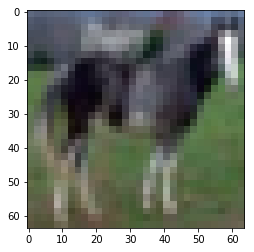

In [13]:
single_image = training_set[28:29]
plt.imshow(single_image[0])         

### Zdjecie warstwy: include_top=False

In [ ]:
#first_model = cnn_model(IMG_SIZE,NUM_CLASSES)

In [14]:
second_model = keras.applications.vgg16.VGG16(include_top=False, weights='imagenet', input_tensor=None, input_shape=(64,64,3), pooling=max)

58195968/58889256 [============================>.] - ETA: 0s

### Choose model (remember to set NUM_CLASSES)

In [15]:
#model = first_model
model = second_model

In [ ]:
model.layers

In [ ]:
model.layers[2]

### Setting all layers to trainable

In [16]:
for layer in model.layers: layer.trainable=True

In [ ]:
model.summary()

### Alternative way to add last layer and activation 

In [17]:
#model.add(Dense(NUM_CLASSES, activation='softmax')) .add doesn't work for VGG16

last = model.output

x = Flatten()(last)
preds = Dense(NUM_CLASSES, activation='softmax')(x)

model = Model(model.input, preds)

In [ ]:
model.layers

In [ ]:
model.summary()

### Set optimizer for tweaks (leraning rate lr=0.001 to lr=0.0001) !Unquote Adam!

In [18]:
Adam=keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

In [19]:
model.compile(optimizer=Adam,loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [23]:
#1st model
#model.fit(x_train, y_train, batch_size=128, epochs=10)
#2nd model
#model.fit(x_train_vgg, y_train_vgg, batch_size=128, epochs=2)
model.fit(training_set, training_labels, batch_size=128, nb_epoch=1, validation_data=(validation_set, validation_labels))

/usr/local/lib/python3.5/site-packages/ipykernel_launcher.py:5: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """


Train on 39942 samples, validate on 10058 samples
Epoch 1/1
39942/39942 [==============================] - 252s - loss: 0.1244 - acc: 0.9563 - val_loss: 0.3599 - val_acc: 0.8966


### Set test size to 64x64

In [24]:
x_test_vgg = np.zeros((10000,64,64,3))

for i in range(10000):
    x_test_vgg[i] = transform.resize(x_test[i], (64, 64), order=0)

/usr/local/lib/python3.5/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [25]:
print (x_test_vgg.shape)

(10000, 64, 64, 3)


In [26]:
model.evaluate(x_test_vgg, y_test)

10000/10000 [==============================] - 22s    


[0.38704311814904213, 0.88839999999999997]